## Clustering Models Notebook

In this notebook, i will explore K-means clustring model to segment customers based on their purchase behavior.

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('C:/Users/danie/Documents/GitHub/customer-loyalty-segmentation/data/processed/customer_features.csv')

In [4]:
df

,Customer ID,Recency,Frequency,Monetary,Total Orders,Average Price
0,12346,0.749138,-0.305504,-0.005997,-0.305504,4.146301
1,12608,-0.530946,-0.430607,-0.446982,-0.430607,-0.855291
2,12745,0.308789,-0.412735,-0.435667,-0.412735,-0.922182
3,12746,0.861785,-0.400820,-0.359005,-0.400820,0.980176
4,12747,-0.889369,0.302139,0.663055,0.302139,1.116461
...,...,...,...,...,...,...
3833,18283,-0.756241,0.754892,0.499472,0.754892,-0.729097
3834,18284,-0.254448,-0.371034,-0.408243,-0.371034,-0.985202
3835,18285,2.090666,-0.454436,-0.442667,-0.454436,0.465418
3836,18286,0.206382,-0.150615,-0.112599,-0.150615,0.144911


#### K-Means Clustering

K-means is an unsupervided learning algorithm that clusters data based on similarity.

The algorithm try to minimize the distance intra-cluster and maximize the distance inter-cluster.

- K is the number of clusters
- Euclidean distance is used almost of times to measure the similarity (distance between two points)
- The algorithm starts by randomly selecting K points as the initial centroids
- K-means is sensible to outliers, because they can affect the centroids
- K-means do not guarantee the global optimum, only the local optimum (depends on the initial centroids)
- K-means assumes that the clusters are spherical and have the same variance

In [5]:
from sklearn.cluster import KMeans

df_customers = df.copy()

features = ['Recency', 'Frequency', 'Monetary', 'Total Orders', 'Average Price']

kmeans = KMeans(n_clusters=4, random_state=42)

df_customers['Cluster'] = kmeans.fit_predict(df_customers[features])

c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [6]:
df_customers[['Customer ID', 'Cluster']].head()

df_customers['Cluster'].value_counts()

Cluster
1    2640
0     951
2     240
3       7
Name: count, dtype: int64

Calculating elbow method to determine optimal number of clusters

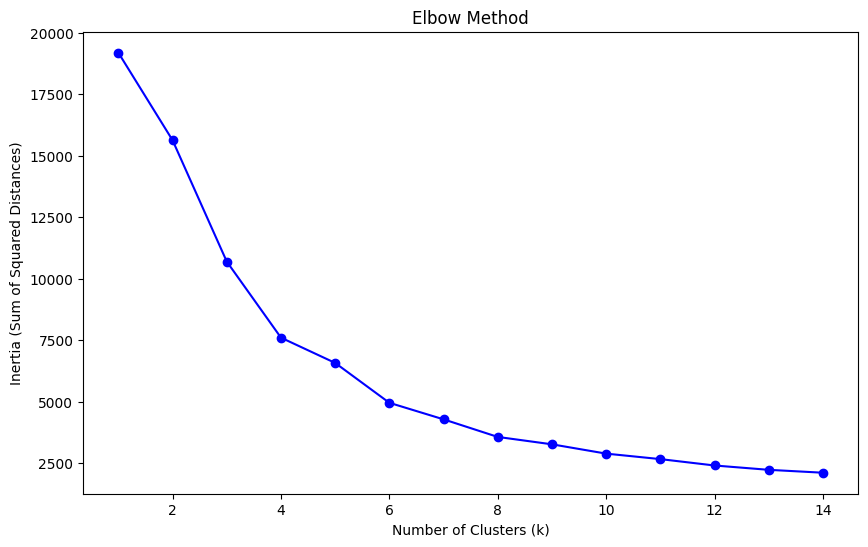

In [7]:
import matplotlib.pyplot as plt

inertia = []
k_values = range(1, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_customers[features])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.show()


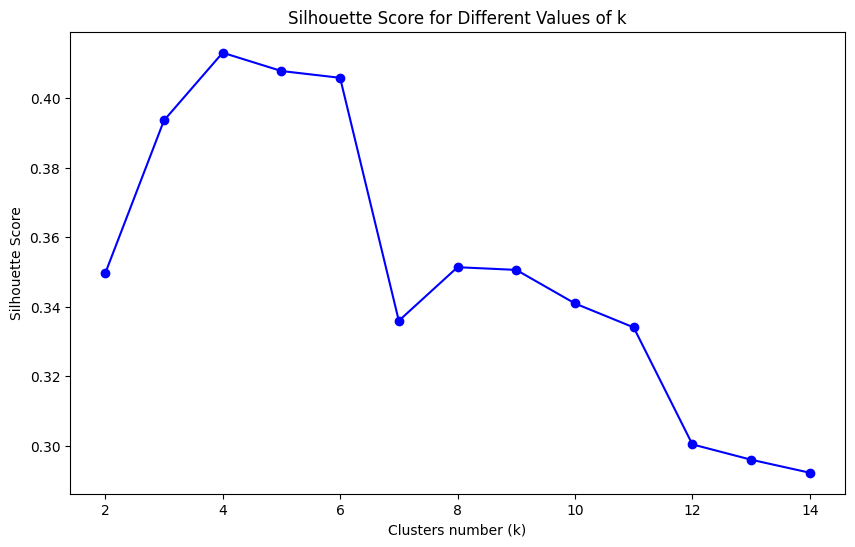

In [8]:
from sklearn.metrics import silhouette_score

sil_scores = []
k_values = range(2, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_customers[features])
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(df_customers[features], labels))

plt.figure(figsize=(10, 6))
plt.plot(k_values, sil_scores, 'bo-')
plt.xlabel('Clusters number (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of k')
plt.show()

In [9]:
print(df_customers['Cluster'].value_counts())

Cluster
1    2640
0     951
2     240
3       7
Name: count, dtype: int64


#### 2D visualization of the clusters

This visualization helps to understand the clusters and their relationships. The idea is to plot the clusters in a 2D space, where each cluster is represented by a different color.

The expectative is to see each cluster in a different space, and the clusters are not overlapping.

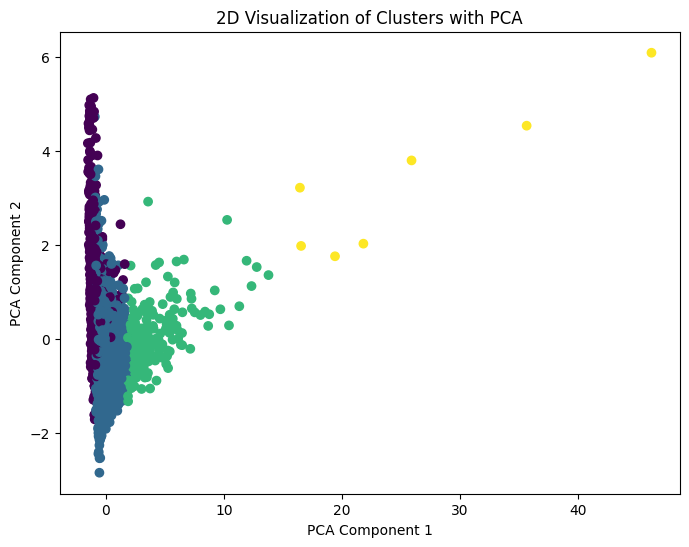

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_customers[features])


plt.figure(figsize=(8,6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_customers['Cluster'], cmap='viridis')
plt.title('2D Visualization of Clusters with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


The pca visualization shows that the clusters are not very well separated, but PCA graph is not the best visualziation to see clusters with high dimensionality.

Now, we will try TSNE visualization to see if the clusters are better separated or if we need to try another clustering algorithm.

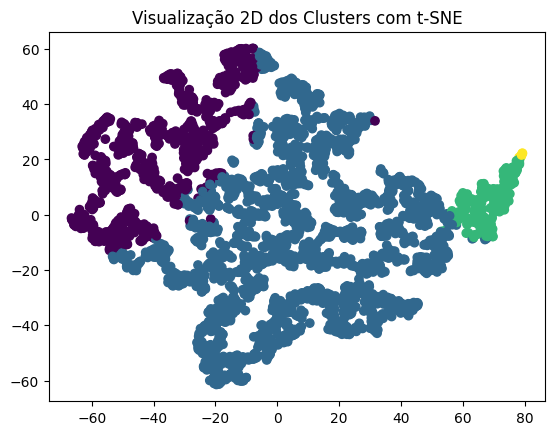

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(df_customers[features])

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df_customers['Cluster'], cmap='viridis')
plt.title('2D Visualization with TSNE')
plt.show()


In [12]:
import joblib

scaler = joblib.load('C:/Users/danie/Documents/GitHub/customer-loyalty-segmentation/scalers/standard_scaler.pkl')

# Supondo que o StandardScaler foi aplicado e salvo como "scaler"
# Invertendo a normalização para voltar os dados à escala original
df_customers[features] = scaler.inverse_transform(df_customers[features])

# Agora que os dados estão desnormalizados, calcular as médias por cluster
cluster_summary = df_customers.groupby('Cluster').mean()

# Exibindo o resumo das características desnormalizadas
print(cluster_summary)


          Customer ID     Recency    Frequency     Monetary  Total Orders  \
Cluster                                                                     
0        15626.688749  240.789695    26.210305    71.203463     26.210305   
1        15543.757197   43.518939    66.131439   163.619136     66.131439   
2        15595.941667   19.787500   439.762500  1065.004008    439.762500   
3        15633.142857    5.714286  2631.428571  6620.175714   2631.428571   

         Average Price  
Cluster                 
0             2.885710  
1             2.537033  
2             2.429447  
3             2.592238  
